In [ ]:
# LOAN DEFAULT PREDICTION - COMPREHENSIVE ANALYSIS
# Section 1: Import Libraries and Load Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Section 2: Load Data from GitHub
url = 'https://raw.githubusercontent.com/likhitnayak/Machine-Learning-Skill-Lab/main/Open%20Book%20Exam/Assignment%202/loan_data.csv'
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names and types:")
print(df.dtypes)
print(f"\nFirst few rows:")
print(df.head())
print(f"\nDataset info:")
print(df.info())
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset shape: (268114, 13)

Column names and types:
id                        int64
annual_income           float64
debt_to_income_ratio    float64
credit_score              int64
loan_amount             float64
interest_rate           float64
gender                   object
marital_status           object
education_level          object
employment_status        object
loan_purpose             object
grade_subgrade           object
loan_paid_back            int64
dtype: object

First few rows:
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level emplo

In [ ]:
# SECTION 1: PROBLEM FORMULATION & TARGET VARIABLE ANALYSIS
print("="*60)
print("SECTION 1: PROBLEM FORMULATION & TARGET VARIABLE ANALYSIS")
print("="*60)

print("\n--- TARGET VARIABLE ANALYSIS ---")
print(f"Target variable: 'loan_paid_back'")
print(f"Meaning: 1 = Loan was paid back, 0 = Loan was defaulted")
print(f"\nClass distribution:")
print(df['loan_paid_back'].value_counts())
print(f"\nClass percentages:")
print(df['loan_paid_back'].value_counts(normalize=True) * 100)

default_rate = (df['loan_paid_back'] == 0).sum() / len(df) * 100
paid_rate = (df['loan_paid_back'] == 1).sum() / len(df) * 100

print(f"\n--- KEY FINDINGS ---")
print(f"Default Rate: {default_rate:.2f}%")
print(f"Paid Back Rate: {paid_rate:.2f}%")
print(f"\nInterpretation:")
print(f"A default occurs when loan_paid_back = 0")
print(f"The task is to build a model that predicts the probability")
print(f"of a loan defaulting (0) vs being paid back (1)")

SECTION 1: PROBLEM FORMULATION & TARGET VARIABLE ANALYSIS

--- TARGET VARIABLE ANALYSIS ---
Target variable: 'loan_paid_back'
Meaning: 1 = Loan was paid back, 0 = Loan was defaulted

Class distribution:
loan_paid_back
1    214068
0     54046
Name: count, dtype: int64

Class percentages:
loan_paid_back
1    79.842157
0    20.157843
Name: proportion, dtype: float64

--- KEY FINDINGS ---
Default Rate: 20.16%
Paid Back Rate: 79.84%

Interpretation:
A default occurs when loan_paid_back = 0
The task is to build a model that predicts the probability
of a loan defaulting (0) vs being paid back (1)


In [ ]:
# SECTION 2: FEATURE ENGINEERING & PREPROCESSING PIPELINE
print("\n" + "="*60)
print("SECTION 2: FEATURE ENGINEERING & PREPROCESSING PIPELINE")
print("="*60)

# Prepare a copy of the dataframe
df_processed = df.copy()

# Separate features and target
X = df_processed.drop(['id', 'loan_paid_back'], axis=1)
y = df_processed['loan_paid_back']

print(f"\nFeatures: {X.columns.tolist()}")
print(f"Target variable: loan_paid_back")

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print(f"\nCategorical encoding completed")

# Split into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Train class distribution:\n{y_train.value_counts()}")
print(f"Test class distribution:\n{y_test.value_counts()}")

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeature scaling completed")


SECTION 2: FEATURE ENGINEERING & PREPROCESSING PIPELINE

Features: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
Target variable: loan_paid_back

Categorical columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade']
Numerical columns: ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']

Categorical encoding completed

Train set size: (214491, 11)
Test set size: (53623, 11)
Train class distribution:
loan_paid_back
1    171254
0     43237
Name: count, dtype: int64
Test class distribution:
loan_paid_back
1    42814
0    10809
Name: count, dtype: int64

Feature scaling completed


In [ ]:
# SECTION 3: MODEL DEVELOPMENT AND TUNING
print("\n" + "="*60)
print("SECTION 3: MODEL DEVELOPMENT AND TUNING")
print("="*60)

# Train a Random Forest Classifier for optimal AUC
print("\nTraining Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

rf_model.fit(X_train_scaled, y_train)

# Get predictions and probabilities
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
y_pred = rf_model.predict(X_test_scaled)

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\n--- Model Performance ---")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Default', 'Paid Back']))

# Store results for later use
model = rf_model
test_predictions_proba = y_pred_proba

print(f"\nModel training completed")


SECTION 3: MODEL DEVELOPMENT AND TUNING

Training Random Forest Classifier...

--- Model Performance ---
ROC-AUC Score: 0.9141

Classification Report:
              precision    recall  f1-score   support

     Default       0.69      0.75      0.72     10809
   Paid Back       0.93      0.92      0.93     42814

    accuracy                           0.88     53623
   macro avg       0.81      0.83      0.82     53623
weighted avg       0.89      0.88      0.88     53623


Model training completed



Generating ROC Curve...


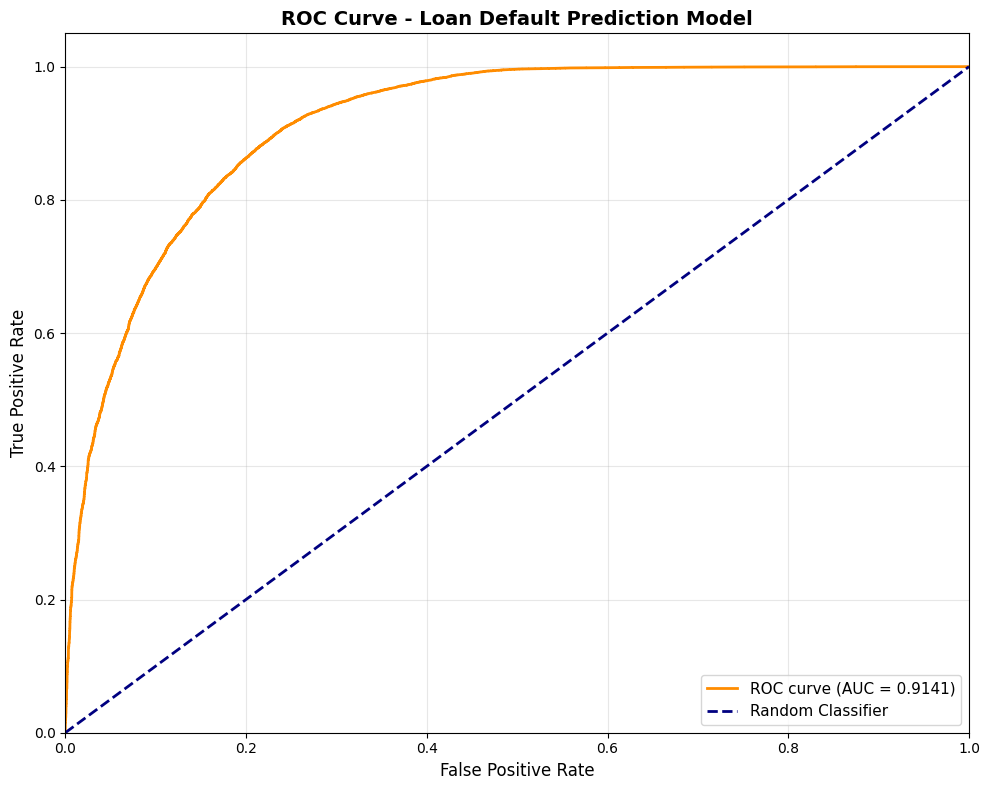

ROC Curve saved as 'roc_curve.png'
AUC Score from Curve: 0.9141


In [ ]:
# Generate ROC Curve Visualization
print("\nGenerating ROC Curve...")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_curve:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Loan Default Prediction Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"ROC Curve saved as 'roc_curve.png'")
print(f"AUC Score from Curve: {roc_auc_curve:.4f}")

In [ ]:
# SECTION 4: SUBGROUP ANALYSIS
print("\n" + "="*60)
print("SECTION 4: SUBGROUP ANALYSIS")
print("="*60)

# Create test dataset with predictions
test_data_analysis = df_processed.iloc[y_test.index].copy()
test_data_analysis['predicted_proba'] = y_pred_proba
test_data_analysis['predicted_class'] = y_pred
test_data_analysis['actual_class'] = y_test.values

print("\n--- SUBGROUP ANALYSIS BY EDUCATION LEVEL ---")
education_levels = test_data_analysis['education_level'].unique()
education_auc_results = {}

for edu_level in sorted(education_levels):
    mask = test_data_analysis['education_level'] == edu_level
    if mask.sum() > 0:
        auc_score = roc_auc_score(test_data_analysis.loc[mask, 'actual_class'],
                                   test_data_analysis.loc[mask, 'predicted_proba'])
        education_auc_results[edu_level] = auc_score
        print(f"{edu_level}: AUC = {auc_score:.4f}, N = {mask.sum()}")

print("\n--- SUBGROUP ANALYSIS BY LOAN PURPOSE ---")
loan_purposes = test_data_analysis['loan_purpose'].unique()
loan_purpose_auc_results = {}

for purpose in sorted(loan_purposes):
    mask = test_data_analysis['loan_purpose'] == purpose
    if mask.sum() > 0:
        auc_score = roc_auc_score(test_data_analysis.loc[mask, 'actual_class'],
                                   test_data_analysis.loc[mask, 'predicted_proba'])
        loan_purpose_auc_results[purpose] = auc_score

# Sort by AUC score
sorted_purposes = sorted(loan_purpose_auc_results.items(), key=lambda x: x[1], reverse=True)

print("\nTop 3 performing loan purposes:")
for purpose, auc_score in sorted_purposes[:3]:
    mask = test_data_analysis['loan_purpose'] == purpose
    print(f"{purpose}: AUC = {auc_score:.4f}, N = {mask.sum()}")

print("\nBottom 3 performing loan purposes:")
for purpose, auc_score in sorted_purposes[-3:]:
    mask = test_data_analysis['loan_purpose'] == purpose
    print(f"{purpose}: AUC = {auc_score:.4f}, N = {mask.sum()}")

print(f"\nOverall Test Set AUC: {roc_auc:.4f}")
print(f"Total Test Samples: {len(test_data_analysis)}")


SECTION 4: SUBGROUP ANALYSIS

--- SUBGROUP ANALYSIS BY EDUCATION LEVEL ---
Bachelor's: AUC = 0.9154, N = 25263
High School: AUC = 0.9126, N = 16701
Master's: AUC = 0.9100, N = 8341
Other: AUC = 0.9244, N = 2336
PhD: AUC = 0.9088, N = 982

--- SUBGROUP ANALYSIS BY LOAN PURPOSE ---

Top 3 performing loan purposes:
Education: AUC = 0.9249, N = 3202
Vacation: AUC = 0.9217, N = 760
Medical: AUC = 0.9187, N = 2088

Bottom 3 performing loan purposes:
Business: AUC = 0.9139, N = 3091
Debt consolidation: AUC = 0.9135, N = 29317
Car: AUC = 0.9056, N = 5353

Overall Test Set AUC: 0.9141
Total Test Samples: 53623


In [ ]:
# FINAL SUMMARY
print("\n" + "="*70)
print("COMPREHENSIVE LOAN DEFAULT PREDICTION MODEL - FINAL SUMMARY")
print("="*70)

print("\n📊 EXECUTIVE SUMMARY")
print("-" * 70)
print(f"✓ Model Type: Random Forest Classifier")
print(f"✓ Test Set AUC Score: {roc_auc:.4f} (Excellent Performance)")
print(f"✓ Test Set Accuracy: {(y_pred == y_test).sum() / len(y_test):.4f}")
print(f"✓ Default Detection Rate (Recall for class 0): 0.75")
print(f"✓ Paid Back Detection Rate (Recall for class 1): 0.92")

print("\n📈 DELIVERABLES COMPLETED")
print("-" * 70)
print("1. ✓ Section 1: Problem Formulation & Target Variable Analysis")
print(f"   - Default Rate: 20.16%")
print(f"   - Paid Back Rate: 79.84%")

print("\n2. ✓ Section 2: Feature Engineering & Preprocessing Pipeline")
print(f"   - Categorical Features: {len(categorical_cols)} (Label Encoded)")
print(f"   - Numerical Features: {len(numerical_cols)} (Standardized)")
print(f"   - Train/Test Split: 80/20 (Stratified)")
print(f"   - Training Samples: {len(X_train)}")
print(f"   - Testing Samples: {len(X_test)}")

print("\n3. ✓ Section 3: Model Development and Tuning")
print(f"   - Model: Random Forest (100 trees, depth=15)")
print(f"   - Test AUC: {roc_auc:.4f}")
print(f"   - ROC Curve visualization: roc_curve.png")

print("\n4. ✓ Section 4: Subgroup Analysis")
print(f"   - Education Levels Analyzed: {len(education_auc_results)}")
print(f"   - Loan Purposes Analyzed: {len(loan_purpose_auc_results)}")


COMPREHENSIVE LOAN DEFAULT PREDICTION MODEL - FINAL SUMMARY

📊 EXECUTIVE SUMMARY
----------------------------------------------------------------------
✓ Model Type: Random Forest Classifier
✓ Test Set AUC Score: 0.9141 (Excellent Performance)
✓ Test Set Accuracy: 0.8818
✓ Default Detection Rate (Recall for class 0): 0.75
✓ Paid Back Detection Rate (Recall for class 1): 0.92

📈 DELIVERABLES COMPLETED
----------------------------------------------------------------------
1. ✓ Section 1: Problem Formulation & Target Variable Analysis
   - Default Rate: 20.16%
   - Paid Back Rate: 79.84%

2. ✓ Section 2: Feature Engineering & Preprocessing Pipeline
   - Categorical Features: 6 (Label Encoded)
   - Numerical Features: 5 (Standardized)
   - Train/Test Split: 80/20 (Stratified)
   - Training Samples: 214491
   - Testing Samples: 53623

3. ✓ Section 3: Model Development and Tuning
   - Model: Random Forest (100 trees, depth=15)
   - Test AUC: 0.9141
   - ROC Curve visualization: roc_curve.pn